In [6]:
%pip install numpy
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import random
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUM_GENERATIONS = 500
MUTATION_PROB = 0.1
MAX_STAGNANT = 200  # Stop if no improvement for 200 generations


DEPOT = (50, 50)

X_RANGE = (0, 100)
Y_RANGE = (0, 100)

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])


def calculate_distance_matrix(locations):
    """
    Precompute all pairwise distances between depot/customers.
    - Input: list of coordinates (depot + customer locations).
    - Output: NxN matrix of distances, where N = number of locations.
    Used for fast lookup during fitness evaluation.
    """

    N = len(locations)
    distance_matrix = [[0.0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            distance_matrix[i][j] = euclidean_distance(locations[i], locations[j])

    return distance_matrix



# --- Genetic Algorithm Components ---
def create_individual(num_customers, num_vehicles):
    """
    Create one random solution (chromosome).
    - Customers randomly shuffled and assigned to vehicles.
    - Each vehicle route starts and ends at the depot [0, ..., 0].
    - Some vehicles may get no customers -> represented as [0, 0].
    """

    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)

    routes = [[] for _ in range(num_vehicles)]
    for customer in customers:
      routes[random.randint(0, num_vehicles - 1)].append(customer)

    # Add depot as start and end points for each vehicle route; otherwise [0,0]
    return [[0] + route + [0] if route else [0, 0] for route in routes]



def solution_distance(solution, distance_matrix):
    """
    Fitness function: calculate the total travel distance of a solution.
    - Loops through all routes.
    - Skips empty routes ([0, 0]).
    - Adds up distances between consecutive nodes using the precomputed matrix.
    """

    total = 0.0
    for route in solution:
      if len(route) > 2: # Skip empty [0, 0] routes
          for i in range(len(route) - 1):
              total += distance_matrix[route[i]][route[i+1]]

    return total


# Used ChatGPT to adjust the crossover for the Vehicle Routing Problem
def crossover(parent1, parent2, num_vehicles, pc=0.8):
    """
    Route-based crossover operator.
    - With probability (1 - pc), simply copies parent1.
    - Otherwise:
        1. Randomly selects full routes from parent1.
        2. Copies those customers into the child.
        3. Fills remaining customers from parent2 (no duplicates).
        4. Wraps each route with depot [0, ..., 0].
    Allows empty routes ([0, 0]) → ensures GA can reduce vehicle usage naturally.
    """

    #With probability (1 - pc), skip crossover and just return a copy of a parent
    if random.random() > pc:
        return [route[:] for route in parent1]

    child = [[] for _ in range(num_vehicles)]
    # Randomly choose a number of routes to take from parent1
    chosen_routes = random.sample(range(num_vehicles), k=random.randint(1, num_vehicles))
    assigned = set()

    for i in chosen_routes:
      child[i] = parent1[i][1:-1] # Customers only, i.e. skip start and end depot
      assigned.update(child[i])


    # Get all customers from parent2 that haven't already been assigned
    unassigned_customers = []
    for route in parent2:
      for customer in route[1:-1]:  # skip depot at start and end
        if customer not in assigned:
          unassigned_customers.append(customer)

    # Try to assign these customers to child routes,
    # roughly matching the length of the routes in parent2
    customer_index = 0
    for vehicle_index in range(num_vehicles):
        target_length = len(parent2[vehicle_index]) - 2  # exclude depot
        while (customer_index < len(unassigned_customers) and
              len(child[vehicle_index]) < target_length):
            customer = unassigned_customers[customer_index]
            child[vehicle_index].append(customer)
            customer_index += 1



    return [[0] + route + [0] if route else [0, 0] for route in child]



def tournament_selection(population, distance_matrix, k=3):
    """
    Selection operator (tournament selection).
    - Randomly samples k solutions from the population.
    - Returns the best (lowest-distance) among them.
    Provides selection pressure while keeping diversity.
    """

    candidates = random.sample(population, k)
    #print(f"Tournament: {tournament}")
    return min(candidates, key=lambda x: solution_distance(x, distance_matrix))


# Used ChatGPT to optimize the mutation for VRP
def mutate(solution, mutation_prob):
    """
    Mutation operator (route rebalancing).
    - With probability mutation_prob:
        1. Selects a random non-empty source route.
        2. Removes a random customer from it.
        3. Inserts the customer into a random position in another route.
    - If a route becomes empty, it collapses into [0, 0].
    This enables dynamic adjustment of vehicle usage.
    """

    if random.random() > mutation_prob:
        return solution

    new_solution = [route[:] for route in solution]
    non_epmty = [i for i, route in enumerate(new_solution) if len(route) > 2]
    if not non_epmty:
      return new_solution

    src = random.choice(non_epmty)
    dst = random.choice([i for i in range(len(new_solution)) if i != src])


    i = random.randint(1, len(new_solution[src]) - 2)
    customer = new_solution[src].pop(i)

    insert_pos = random.randint(1, len(new_solution[dst]) -1)
    new_solution[dst].insert(insert_pos, customer)
    return new_solution


# --- Main Genetic Algorithm ---
def genetic_algorithm(distance_matrix, num_customers, pop_size=20, num_vehicles=3, generations=300, mutation_prob=0.1, tournament_size=3):
    """
    Main Genetic Algorithm loop for solving VRP.
    Steps:
    1. Initialize population with random solutions.
    2. For each generation:
       - Sort population by fitness (distance).
       - Track best solution and apply early stopping if no improvement.
       - Generate new population:
           * Select parents with tournament selection.
           * Apply crossover (route-based).
           * Apply mutation (move customers between routes).
       - Apply elitism (carry best solution forward).
    3. Return the best solution and history of best distances per generation.
    """

    population = [create_individual(num_customers, num_vehicles) for _ in range(pop_size)]
    all_histories = []

    best_distance_so_far = float('inf')
    stagnant_generations = 0

    for gen in range(generations):
        population.sort(key=lambda s: solution_distance(s, distance_matrix))
        current_best = solution_distance(population[0], distance_matrix)
        all_histories.append(current_best)

        if current_best < best_distance_so_far:
            best_distance_so_far = current_best
            stagnant_generations = 0
        else:
            stagnant_generations += 1

        if stagnant_generations >= MAX_STAGNANT:
            print(f"No improvement for {MAX_STAGNANT} generations. Terminating at generation {gen}.")
            break

        #print(f"Generation {gen}: Best Distance = {current_best:.2f}")

        new_population = []
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, distance_matrix, tournament_size)
            p2 = tournament_selection(population, distance_matrix, tournament_size)
            c1, c2 = crossover(p1, p2, num_vehicles), crossover(p2, p1, num_vehicles)

            c1 = mutate(c1, mutation_prob)
            c2 = mutate(c2, mutation_prob)
            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        # Elitism; Keep the best solution from current generation
        population = [population[0]] + new_population[:-1]


    best_solution = min(population, key=lambda s: solution_distance(s, distance_matrix))
    best_solution = [r for r in best_solution if len(r) > 2]
    return best_solution, solution_distance(best_solution, distance_matrix), all_histories



def run_experiment(generations, mutation_prob, distance_matrix, num_runs=20):
    """
    Run the GA multiple times to measure performance stability.
    - Executes genetic_algorithm num_runs times.
    - Collects best, worst, mean, and std deviation of results.
    - Tracks average fitness convergence curve across runs.
    - Measures average runtime.
    Returns:
        stats dictionary + overall best solution.
    """

    results = {}
    best_routes= []
    all_histories = []
    best_solution_overall = None
    best_distance_overall = float('inf')

    start_time = time.time()

    for _ in range(num_runs):
        best_solution, best_distance, history = genetic_algorithm(
        distance_matrix,
        num_customers=NUM_CUSTOMERS,
        num_vehicles=NUM_VEHICLES,
        pop_size=NUM_CUSTOMERS,
        generations=NUM_GENERATIONS,
        mutation_prob=MUTATION_PROB
        )
        best_routes.append(best_distance)
        all_histories.append(history)

        if best_distance < best_distance_overall:
            best_distance_overall = best_distance
            best_solution_overall = best_solution

    end_time = time.time()
    total_time = end_time - start_time
    avg_run_time = total_time/num_runs
    df = pd.DataFrame(all_histories).T  # Transpose to get generations as rows
    avg_history = df.mean(axis=1).to_numpy()
    results = {
        "best": min(best_routes),
        "worst": max(best_routes),
        "mean": np.mean(best_routes),
        "std_dev": np.std(best_routes),
        "avg_best_fitness": avg_history,
        "avg_run_time": avg_run_time
    }

    print(f"Statistics for Population Size {NUM_CUSTOMERS}")
    print(f"Best: {min(best_routes):.2f}, Worst: {max(best_routes):.2f}, Mean: {np.mean(best_routes):.2f}, Std Dev: {np.std(best_routes):.2f}\n")
    print(f"Average Time per Run: {avg_run_time:.2f} seconds\n")

    return results, best_solution_overall


def plot_route(solution, locations):
    """
    Visualization helper.
    - Draws the final routes for all vehicles on a 2D plane.
    - Depot shown in red, customers labeled as C1, C2, ...
    - Also prints textual routes to console.
    Used to interpret and validate the GA’s final solution.
    """

    plt.figure(figsize=(10, 8))
    for vehicle_idx, route in enumerate(solution):
        route_coords = [locations[i] for i in route]
        xs, ys = zip(*route_coords)
        plt.plot(xs, ys, marker='o', label=f"Vehicle {vehicle_idx + 1}")


        print(f"Vehicle {vehicle_idx + 1}: " + " -> ".join(map(str, route)))

    plt.scatter(*DEPOT, color='red', s=100, label='Depot')
    for i, (x, y) in enumerate(locations[1:], start=1):
        plt.text(x, y, f"C{i}", fontsize=9)

    plt.title("Best Route for Vehicles")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
customers_small_1 = [(15, 23), (48, 55), (1, 54), (37, 63), (83, 45), (99, 93), (38, 32), (12, 22), (79, 49), (26, 24), (87, 31), (13, 73), (90, 74), (66, 61), (75, 71), (69, 5), (78, 11), (45, 88), (65, 99), (6, 31)]
customers_small_2 = [(52, 36), (92, 81), (3, 96), (40, 77), (83, 66), (74, 0), (19, 53), (80, 36), (77, 42), (86, 94), (67, 67), (34, 24), (20, 29), (84, 4)]
customers_medium_1 = [(49, 24), (29, 78), (0, 97), (63, 2), (52, 96), (96, 34), (63, 78), (45, 75), (13, 63), (76, 87), (7, 75), (53, 22), (93, 89), (1, 23), (30, 86), (25, 90)]
customer_medium_2 = [(70, 86), (51, 54), (51, 41), (78, 90), (11, 21), (42, 38), (47, 88), (33, 78), (14, 2), (44, 42), (91, 20), (46, 51), (88, 41), (92, 59), (2, 83), (58, 1), (88, 20), (93, 65), (84, 61), (29, 14), (94, 29), (43, 83), (56, 61), (21, 18), (83, 72), (76, 96), (58, 91)]
customer_large_1 = [(27, 95), (24, 97), (91, 79), (79, 76), (2, 76), (58, 34), (6, 75), (36, 66), (23, 8), (54, 59), (22, 53), (64, 20), (39, 0), (50, 95), (10, 76), (88, 85), (49, 12), (97, 36), (76, 94), (83, 59), (16, 63), (99, 85), (30, 8), (82, 84), (71, 1), (80, 40), (21, 97), (2, 34), (53, 82), (58, 47), (99, 65), (15, 43), (0, 14), (19, 4), (54, 76), (90, 100)]
customer_large_2 = [(92, 92), (98, 9), (65, 71), (77, 96), (5, 75), (25, 8), (6, 64), (30, 32), (6, 65), (51, 9), (1, 22), (90, 63), (94, 17), (20, 45), (70, 79), (74, 69), (31, 93), (30, 36), (82, 41), (67, 87), (26, 55), (17, 63), (80, 20), (57, 71), (79, 94), (17, 86), (87, 57), (81, 32), (9, 61), (51, 89), (41, 94), (71, 83), (68, 0), (53, 8), (98, 71), (59, 40), (24, 50), (97, 25), (3, 73), (72, 97), (61, 68), (7, 11), (24, 63), (46, 27), (12, 20), (80, 2), (34, 100), (39, 74), (55, 41)]

print(len(customer_large_2))
vehicles_small_1 = 7
vehicles_small_2 = 3
vehicles_medium_1 = 14
vehicles_medium_2 = 23
vehicles_large_1 = 29
vehicles_large_2 = 45




49



--- Running Scenario: Small 1 ---
No improvement for 200 generations. Terminating at generation 382.
No improvement for 200 generations. Terminating at generation 436.
No improvement for 200 generations. Terminating at generation 463.
No improvement for 200 generations. Terminating at generation 397.
Statistics for Population Size 20
Best: 524.43, Worst: 655.38, Mean: 576.62, Std Dev: 30.99

Average Time per Run: 0.14 seconds

Best Distance for Small 1: 524.43
Vehicle 1: 0 -> 2 -> 14 -> 9 -> 5 -> 11 -> 17 -> 16 -> 0
Vehicle 2: 0 -> 7 -> 19 -> 6 -> 13 -> 15 -> 18 -> 4 -> 10 -> 1 -> 8 -> 20 -> 3 -> 12 -> 0


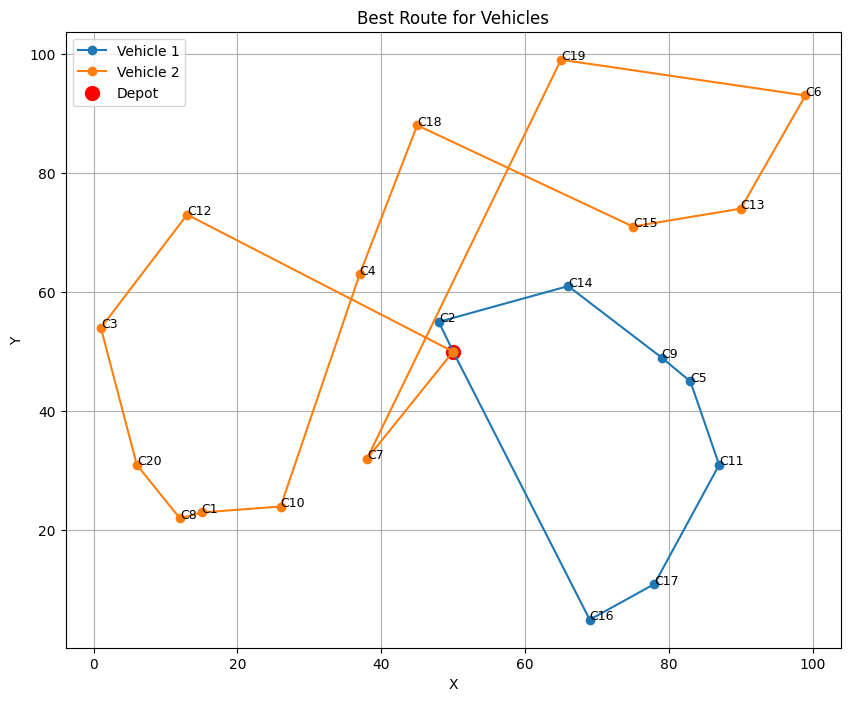


--- Running Scenario: Small 2 ---
No improvement for 200 generations. Terminating at generation 410.
No improvement for 200 generations. Terminating at generation 257.
No improvement for 200 generations. Terminating at generation 445.
No improvement for 200 generations. Terminating at generation 258.
No improvement for 200 generations. Terminating at generation 470.
No improvement for 200 generations. Terminating at generation 369.
No improvement for 200 generations. Terminating at generation 239.
No improvement for 200 generations. Terminating at generation 288.
No improvement for 200 generations. Terminating at generation 375.
No improvement for 200 generations. Terminating at generation 477.
No improvement for 200 generations. Terminating at generation 354.
No improvement for 200 generations. Terminating at generation 435.
No improvement for 200 generations. Terminating at generation 455.
Statistics for Population Size 14
Best: 444.16, Worst: 546.53, Mean: 485.66, Std Dev: 26.09

A

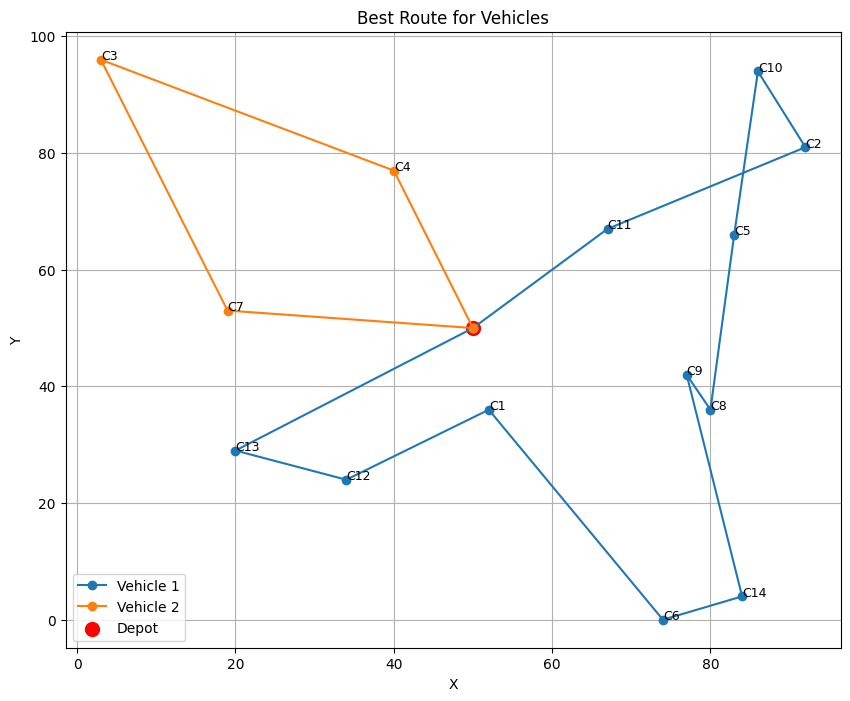


--- Running Scenario: Medium 1 ---
No improvement for 200 generations. Terminating at generation 434.
No improvement for 200 generations. Terminating at generation 354.
No improvement for 200 generations. Terminating at generation 411.
No improvement for 200 generations. Terminating at generation 380.
No improvement for 200 generations. Terminating at generation 463.
Statistics for Population Size 16
Best: 522.35, Worst: 719.63, Mean: 608.88, Std Dev: 44.49

Average Time per Run: 0.13 seconds

Best Distance for Medium 1: 522.35
Vehicle 1: 0 -> 14 -> 9 -> 11 -> 3 -> 15 -> 16 -> 8 -> 7 -> 10 -> 13 -> 5 -> 2 -> 0
Vehicle 2: 0 -> 1 -> 4 -> 12 -> 6 -> 0


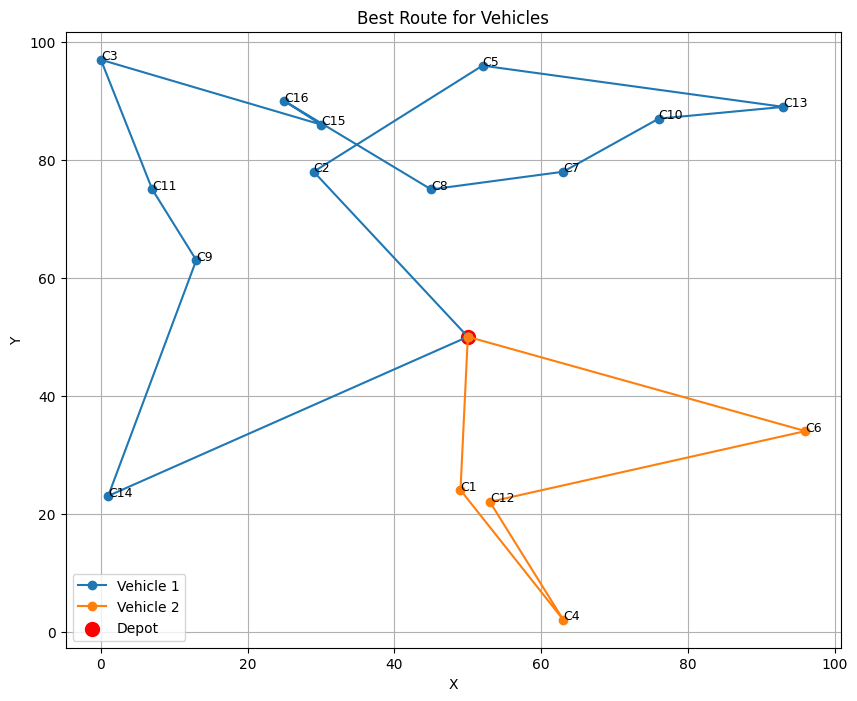


--- Running Scenario: Medium 2 ---
Statistics for Population Size 27
Best: 722.62, Worst: 858.19, Mean: 785.64, Std Dev: 34.86

Average Time per Run: 0.35 seconds

Best Distance for Medium 2: 722.62
Vehicle 1: 0 -> 4 -> 26 -> 25 -> 18 -> 13 -> 19 -> 14 -> 2 -> 0
Vehicle 2: 0 -> 23 -> 1 -> 27 -> 22 -> 7 -> 15 -> 12 -> 8 -> 0
Vehicle 3: 0 -> 16 -> 17 -> 11 -> 21 -> 3 -> 0
Vehicle 4: 0 -> 6 -> 20 -> 24 -> 5 -> 9 -> 10 -> 0


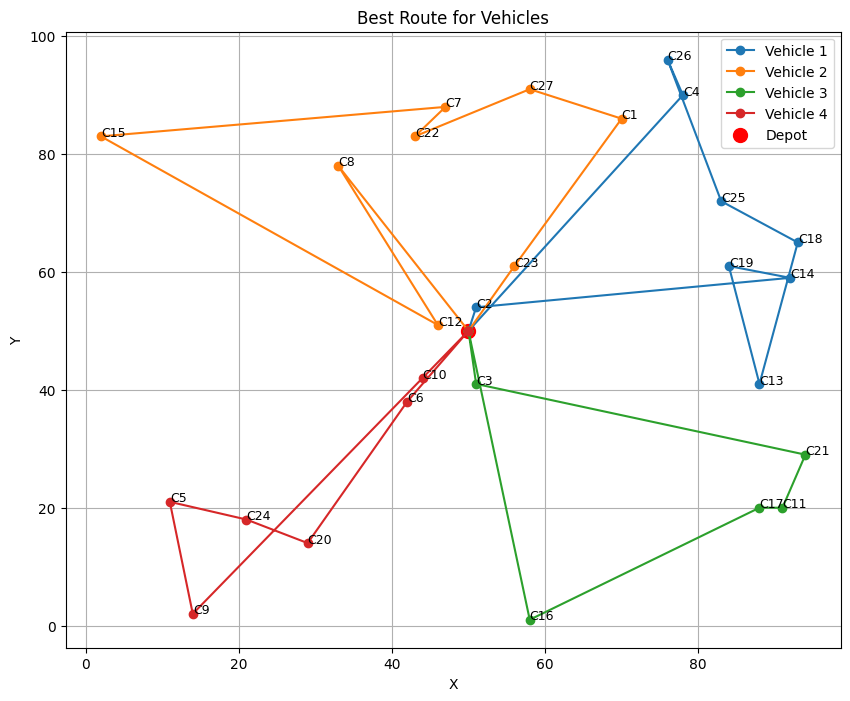


--- Running Scenario: Large 1 ---
Statistics for Population Size 36
Best: 1000.64, Worst: 1259.96, Mean: 1116.64, Std Dev: 70.39

Average Time per Run: 0.57 seconds

Best Distance for Large 1: 1000.64
Vehicle 1: 0 -> 12 -> 13 -> 17 -> 25 -> 6 -> 0
Vehicle 2: 0 -> 4 -> 16 -> 36 -> 22 -> 31 -> 3 -> 19 -> 24 -> 20 -> 0
Vehicle 3: 0 -> 15 -> 2 -> 27 -> 1 -> 8 -> 0
Vehicle 4: 0 -> 26 -> 18 -> 30 -> 0
Vehicle 5: 0 -> 33 -> 28 -> 34 -> 9 -> 23 -> 0
Vehicle 6: 0 -> 32 -> 5 -> 7 -> 21 -> 11 -> 0
Vehicle 7: 0 -> 14 -> 29 -> 35 -> 10 -> 0


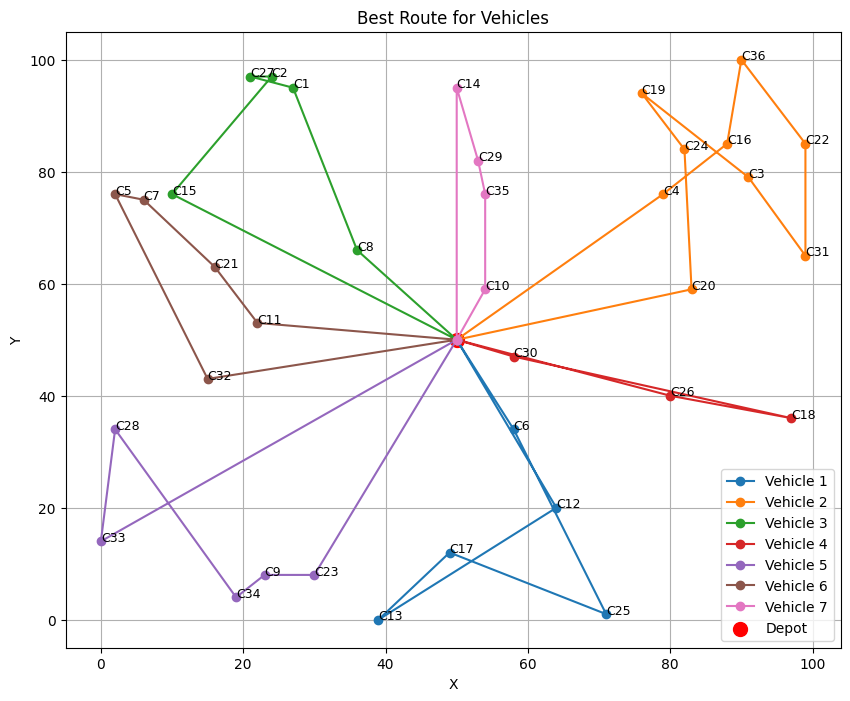


--- Running Scenario: Large 2 ---
Statistics for Population Size 49
Best: 1307.87, Worst: 1592.53, Mean: 1455.82, Std Dev: 71.43

Average Time per Run: 1.28 seconds

Best Distance for Large 2: 1307.87
Vehicle 1: 0 -> 45 -> 6 -> 34 -> 44 -> 14 -> 8 -> 0
Vehicle 2: 0 -> 38 -> 23 -> 33 -> 46 -> 2 -> 13 -> 49 -> 0
Vehicle 3: 0 -> 3 -> 35 -> 1 -> 4 -> 25 -> 40 -> 30 -> 0
Vehicle 4: 0 -> 37 -> 43 -> 0
Vehicle 5: 0 -> 17 -> 47 -> 26 -> 31 -> 18 -> 19 -> 28 -> 0
Vehicle 6: 0 -> 21 -> 22 -> 9 -> 5 -> 39 -> 7 -> 29 -> 11 -> 42 -> 10 -> 0
Vehicle 7: 0 -> 27 -> 12 -> 16 -> 36 -> 0
Vehicle 8: 0 -> 24 -> 20 -> 32 -> 15 -> 41 -> 48 -> 0


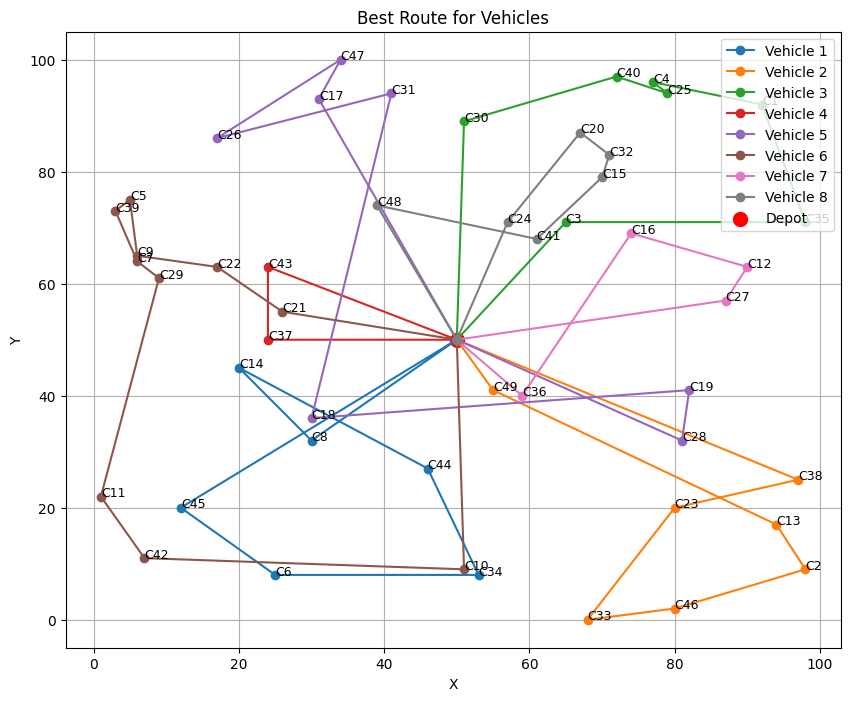

In [9]:
# Define all scenarios
scenarios = [
    {"name": "Small 1", "customers": customers_small_1, "vehicles": vehicles_small_1},
    {"name": "Small 2", "customers": customers_small_2, "vehicles": vehicles_small_2},
    {"name": "Medium 1", "customers": customers_medium_1, "vehicles": vehicles_medium_1},
    {"name": "Medium 2", "customers": customer_medium_2, "vehicles": vehicles_medium_2},
    {"name": "Large 1", "customers": customer_large_1, "vehicles": vehicles_large_1},
    {"name": "Large 2", "customers": customer_large_2, "vehicles": vehicles_large_2}
]

# Store results for all scenarios
all_results = {}

for scenario in scenarios:
    name = scenario["name"]
    customers = scenario["customers"]
    num_vehicles = scenario["vehicles"]

    print(f"\n--- Running Scenario: {name} ---")

    locations = [DEPOT] + customers
    distance_matrix = calculate_distance_matrix(locations)
    NUM_CUSTOMERS = len(customers)
    NUM_VEHICLES = num_vehicles

    results, best_solution = run_experiment(NUM_GENERATIONS, MUTATION_PROB, distance_matrix)

    all_results[name] = {
        "results": results,
        "best_solution": best_solution,
        "locations": locations
    }

    print(f"Best Distance for {name}: {results['best']:.2f}")

    # Optional: plot best routes
    plot_route(best_solution, locations)


In [10]:
# Prepare table data
table_data = []

for name, data in all_results.items():
    res = data["results"]
    table_data.append({
        "Scenario": name,
        "Best Distance": round(res["best"], 2),
        "Worst Distance": round(res["worst"], 2),
        "Mean Distance": round(res["mean"], 2),
        "Std Dev": round(res["std_dev"], 2),
        "Average Time per Run": f"{round(res['avg_run_time'], 2)} s"
    })

# Create a DataFrame for a neat table
results_table = pd.DataFrame(table_data)

# Shift index to start from 1
results_table.index = results_table.index + 1

# Display the table
print("\n--- Summary Table of VRP Scenarios ---")
print(results_table)


--- Summary Table of VRP Scenarios ---
   Scenario  Best Distance  Worst Distance  Mean Distance  Std Dev  \
1   Small 1         524.43          655.38         576.62    30.99   
2   Small 2         444.16          546.53         485.66    26.09   
3  Medium 1         522.35          719.63         608.88    44.49   
4  Medium 2         722.62          858.19         785.64    34.86   
5   Large 1        1000.64         1259.96        1116.64    70.39   
6   Large 2        1307.87         1592.53        1455.82    71.43   

  Average Time per Run  
1               0.14 s  
2               0.06 s  
3               0.13 s  
4               0.35 s  
5               0.57 s  
6               1.28 s  
